# Todo



In [194]:
%matplotlib inline

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import networkx as nx

In [196]:
DATA = './data/'

# Exercise 1: Propensity Score Matching

### Clarification:


- Black and Hispanic people will further be considered as minorities. A column is added to the lalonde dataframe.


- If a subject has a '0' as covariate 're74', 're75' or 're78', the subject is assumed to not have had ANY income in that specific year as specified on Mattermost.


In [197]:
lalonde = pd.read_csv(DATA + 'lalonde.csv', index_col=0)

lalonde['minority'] = lalonde['black'] + lalonde['hispan']

### 1.1 A naive analysis

In this first naive analysis we seperate the data into two groups, where the first group received treatment and the second group did not receive treatment. We compare these groups solely by the real earnings of the subjects in 1978. 


In [198]:
treated = lalonde[(lalonde.treat == 1)]
non_treated = lalonde[(lalonde.treat == 0)]

#### A look at some numbers:


Total subjects: 		614
Number of treated subjects: 	185
Number of control subjects: 	429
Mean income treatment group: 	6349.14
Mean income control group: 	6984.17


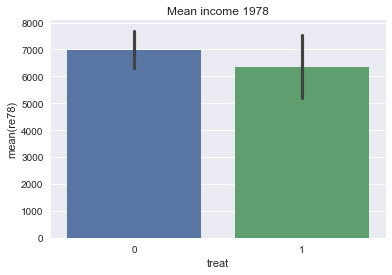

In [199]:
print('Total subjects: ' + '\t' + '\t' +str(len(lalonde)))
print('Number of treated subjects: '+ '\t' + str(len(treated)))
print('Number of control subjects: '+ '\t' + str(len(non_treated)))
print('Mean income treatment group: ' + '\t' +str(round(treated.re78.mean(),2)))
print('Mean income control group: ' +'\t' + str(round(non_treated.re78.mean(),2)))

sns.barplot(x = 'treat', y='re78', data = lalonde).set_title("Mean income 1978")

From the total number of subjects in the experiment only roughly a third received treatment. The mean of the income of the control group after treatment is higher than the mean income of treated subjects. This might lead one to believe, that the treatment is useless. The error bars on the above plot represents the standard deviation. 

#### A look at the distributions:

Below the distributions of the income of the treated and untreated subjects is plotted for the year 1978. The smoothed histograms look quite similar, both being heavily right skewed. In the plot representing the subjects that received treatments some heavy outliers are visible, which explains the large standard deviation observed above.

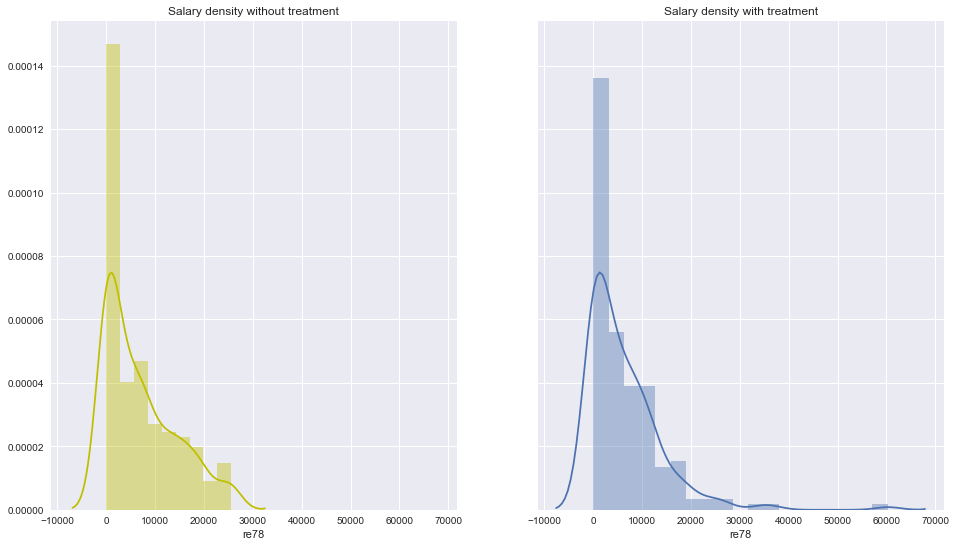

In [200]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9),sharey= True,sharex= True)

axs[0].set_title("Salary density without treatment")
sns.distplot(non_treated.re78, norm_hist=True, kde=True, ax=axs[0], color='y',label ='Not treated')

axs[1].set_title("Salary density with treatment")
sns.distplot(treated.re78, norm_hist=True, kde=True, ax=axs[1])

### 2. A closer look at the data

First we take a look at covariates, which are either true or false for a given subject.

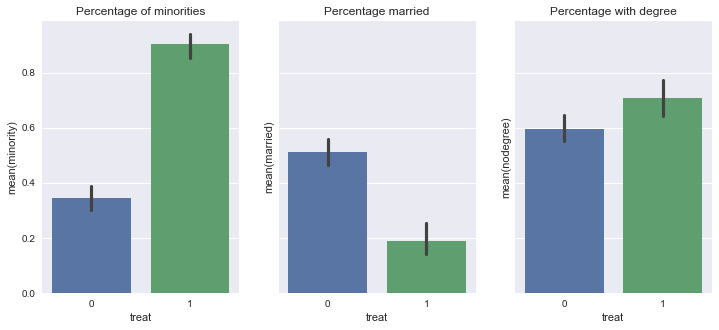

In [201]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x = 'treat',y ='minority', data = lalonde,ax = axs[0]).set_title('Percentage of minorities')
sns.barplot(x = 'treat',y ='married', data = lalonde,ax = axs[1]).set_title('Percentage married')
sns.barplot(x = 'treat',y ='nodegree', data = lalonde,ax = axs[2]).set_title('Percentage with degree')

Clearly the treated subjects were not chosen randomly. They are overwhelmingly composed of unmarried minorites, whereby two thirds do not have a degree. Around half of the control group are married and have degrees and only about a third are minorities.

Next we look at the mean of the age, the average number of years in education and the mean income in 1975 and 1974:

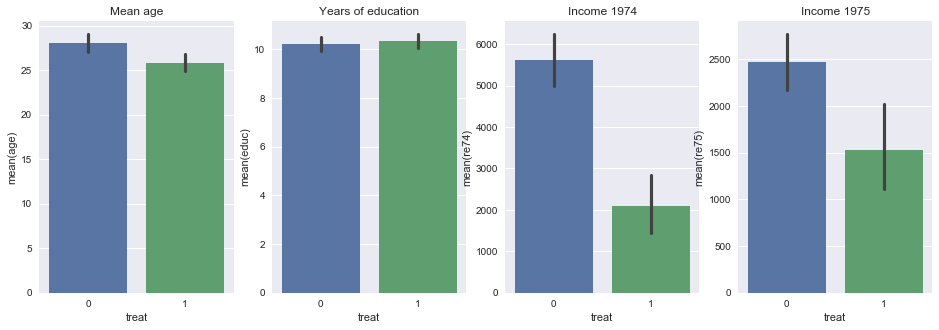

In [202]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.barplot(x = 'treat',y ='age', data = lalonde,ax = axs[0]).set_title('Mean age')
sns.barplot(x = 'treat',y ='educ', data = lalonde,ax = axs[1]).set_title('Years of education')
sns.barplot(x = 'treat',y ='re74', data = lalonde,ax = axs[2]).set_title('Income 1974')
sns.barplot(x = 'treat',y ='re75', data = lalonde,ax = axs[3]).set_title('Income 1975')

Additionally to the above stated differences between the features of the treated subjects towards the control group it is now visible, that the treated subjects are also younger on average and have much less income in the year 1974. In 1975 the control group and the treatment group both have significantly less real earnings, which seems a bit fishy. The average years of education between the two groups is about the same, which is not surprising, because highschool takes twelve years.


### Impact on the conclusions of the naive research:

Naively looking at the outcome of the experiment implies that the treatment was probably a failure. Looking at the data more carefully, we find out:


- The control group is twice as large as the treatment group.


- The treatment group is overwhelmingly comprised of unmarried minorities, a bit more than half of which finished highschool, have almost no real earnings in 1975 and are on average in their mid twenties.


- The control group is far more diverse.


In order to compare the two groups a propensity model is applied.


### 3. A propensity score model

To find the propensity score a linear regression is applied, whereby the 'treated' and the 're78' covariates are dropped and the propensity score is added to the dataframe as an additional covariate. The propensity score gives the probablity of being assigned to the treated group, given a feature vector.

In [205]:
logistic = linear_model.LogisticRegression()

X = lalonde.drop(['treat','re78'],axis=1)
y = lalonde['treat']

model = logistic.fit(X,y)

lalonde['propensity']= model.predict_proba(X)[:,1]
treated = lalonde[(lalonde.treat == 1)]
non_treated = lalonde[(lalonde.treat == 0)]

lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,minority,propensity
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,0.432719
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,0.212375
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0.716758
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,0.651723
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,0.690612


### 4. Balancing the dataset via matching

Now for every subject in the treatment group we find a match in the control group. This is done using the networkx library. 

- We loop over all treated subjects and control subject.


- We create an edge between the subjects whereby the weight is minus the absolute value of the difference between the propensity scores.


- Doing this we have created a fully connected bipartite graph.


- To find the matches the max_weight_matching function from the networkx library is applied, which finds the match for every subject minimizing the sum of the weights. (It minimizes, because the negative absolute difference was chosen, while creating the fully connected bipartite graph.)


- The resulting dictionary gets searched for the values assigned to the keys, which start with 'NSW'. This returns the list of control group subjects, that was matched to the treatment group.


- A new dataframe non_treated_match is created containing the 185 subjects of the control group, that were matched.

- A dataframe is created containing the matched control group and the treatment group appending one to the other.

In [206]:
G = nx.Graph()

for index_t, t in treated.iterrows():
    for index_n, n in non_treated.iterrows():
        w = -np.abs(t.propensity-n.propensity)
        G.add_edge(index_t, index_n, weight=w)

match = nx.max_weight_matching(G,True)

psids = [v for k, v in match.items() if 'NSW' in k]
non_treated_match = non_treated.loc[psids]

matched_experiment = treated.append(non_treated_match)

#### Comparing the outcome of the experiment looking at matched subjets


First the mean real earnings of the matched subjects is shown:

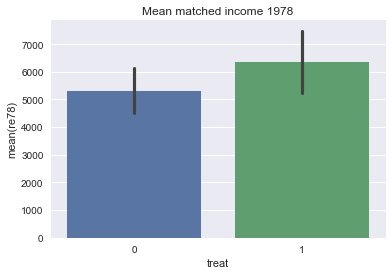

In [207]:
sns.barplot(x = 'treat', y='re78', data = matched_experiment).set_title("Mean matched income 1978")

Alas, it looks like the treatment was a success, after subjects with similar covariates were matched! The mean real earnings of the matched control subjects is lower, than the mean real earnings of the treatment group, even though still quite high standard deviation is present in the treatment group due to outliers. 


To be sure, that our method of matching was reasonable, let's take a look at the features of the matched subjects.


First the age, number of years of education and the income in 1974 and 1975 are compared:

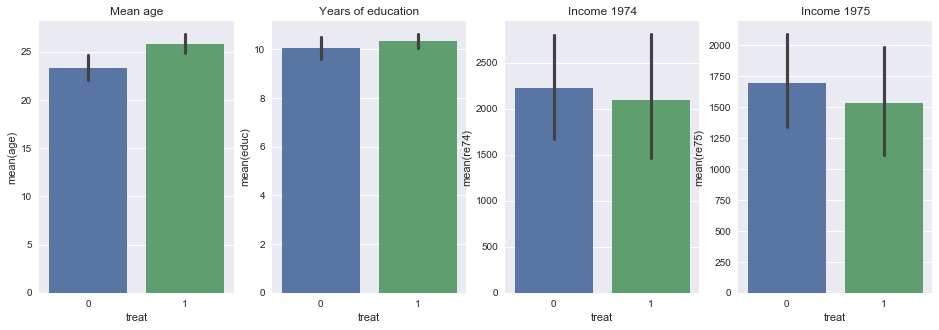

In [208]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.barplot(x = 'treat',y ='age', data = matched_experiment,ax = axs[0]).set_title('Mean age')
sns.barplot(x = 'treat',y ='educ', data = matched_experiment,ax = axs[1]).set_title('Years of education')
sns.barplot(x = 'treat',y ='re74', data = matched_experiment,ax = axs[2]).set_title('Income 1974')
sns.barplot(x = 'treat',y ='re75', data = matched_experiment,ax = axs[3]).set_title('Income 1975')

The income in 1974, which was heavily unbalanced before seems to have been corrected reasonably well, eventhough the large error bars indicate many outliers. Through matching the mean age fell to the other side. Now the control group is on average less than 25 years old.

Next the covariates, which are either true or false are compared:

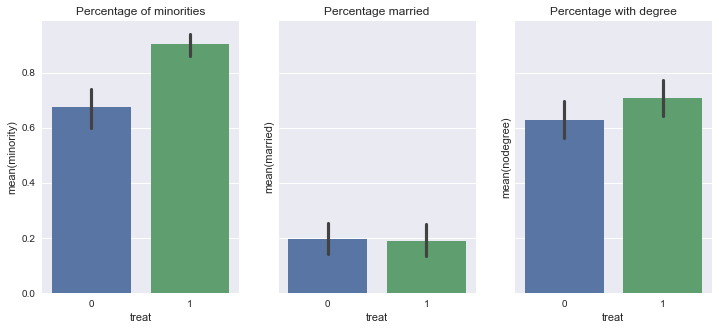

In [209]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5),sharey = True)

sns.barplot(x = 'treat',y ='minority', data = matched_experiment,ax = axs[0]).set_title('Percentage of minorities')
sns.barplot(x = 'treat',y ='married', data = matched_experiment,ax = axs[1]).set_title('Percentage married')
sns.barplot(x = 'treat',y ='nodegree', data = matched_experiment,ax = axs[2]).set_title('Percentage with degree')

The number of subjects having a degree and being married have been matched reasonably well, but the feature of being part of a minority is still heavily over represented in the treatment group. We are closer to being able to draw a valid conclusion, but the difference in percentage of subjects being either black or hispanic is still too large.

### 5. Balancing the groups further

As mentioned above, the matching done is good, but can be improved, because their are still significantly more subjects, that are minorities in the treatment group.

The way we improve our matching is by explicitly focusing on subjects, that are minorites. First we create two new dataframes containing only the matched subjects, which are minorities.

In [264]:
matched_treated_minority = matched_experiment[(matched_experiment.minority == 1) & (matched_experiment.treat == 1)]
matched_non_treated_minority = matched_experiment[(matched_experiment.minority == 1) & (matched_experiment.treat == 0)]

print(str(sum(matched_non_treated_minority.minority)) + ' of the total ' + str(len(matched_experiment[(matched_experiment.treat == 0)])) + ' subjects in the matched control group are minorities.')
print(str(sum(matched_treated_minority.minority)) + ' of the total ' + str(len(matched_experiment[(matched_experiment.treat == 1)])) + ' subjects in the control group are minorities.')


125 of the total 185 subjects in the matched control group are minorities.
167 of the total 185 subjects in the control group are minorities.


#### Improved matching


- We will now perform a second matching on the previously matched members of the treatment and control groups adding the constraint, that we only consider minorities.


- The 125 minority subjects in the matched control group will be matched to one of the 167 minority subjects of the treatment group following the same procedure as described above.

In [265]:
G = nx.Graph()

for index_t, t in matched_treated_minority.iterrows():
    for index_n, n in matched_non_treated_minority.iterrows():
        w = -np.abs(t.propensity-n.propensity)
        G.add_edge(index_t, index_n, weight=w)

match = nx.max_weight_matching(G,True)

nsws = [v for k, v in match.items() if 'PSID' in k]
treated_match_minority = matched_treated_minority.loc[nsws]

matched_experiment_minorities = matched_non_treated_minority.append(treated_match_minority)

#### Inspecting the second match

Looking at the covariates of subject after the second round of matching, we can observe that the additional constraint of subjects having to be a minority, gives us two well balanced groups. Their mean age, years of education, their income in 1974 and the percentage of married subjects are similar.


The real earnings 1975 are not considered. From the beginning the mean in that year is overall just a third of the previous year, which makes it seem like something is wrong with the data. We focus solely on the real earnings at the beginning and at the end of the experiment. The covariate with the information, whether a subject has a degree or not is also not considered here, because it depends strongly on the years of education and does not add much additional information.

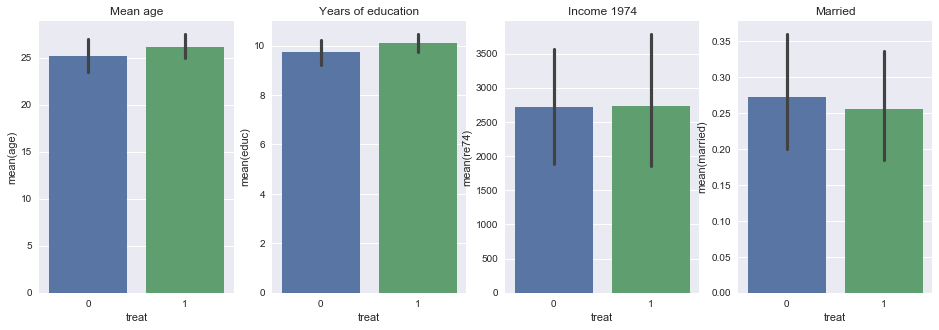

In [271]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

sns.barplot(x = 'treat',y ='age', data = matched_experiment_minorities,ax = axs[0]).set_title('Mean age')
sns.barplot(x = 'treat',y ='educ', data = matched_experiment_minorities,ax = axs[1]).set_title('Years of education')
sns.barplot(x = 'treat',y ='re74', data = matched_experiment_minorities,ax = axs[2]).set_title('Income 1974')
sns.barplot(x = 'treat',y ='married', data = matched_experiment_minorities,ax = axs[3]).set_title('Married')

### 6. A less naive analysis

Now the treatment and control groups are well balanced. They are comprised of subjects, that are all minorities in their twenties, that on average almost finished highschool, have low income at the beginning of the experiment and are mostly unmarried.


The subjects that received treatment had slightly higher real earnings in 1978, than the subjects in the control group, whereby the standard deviation is quite large. Based on these results I conclude, that the experiment did not help this specific demographic group of the population in any significant way.

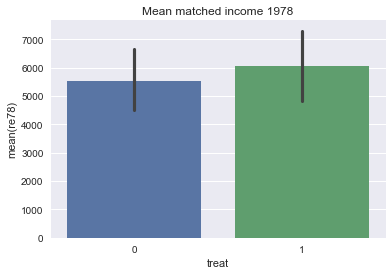

In [273]:
sns.barplot(x = 'treat', y='re78', data = matched_experiment_minorities).set_title("Mean matched income 1978")